Depot Locations:
Object 1 can be picked up from cities: [4, 1, 5]
Object 2 can be picked up from cities: [8, 0, 3, 5]
Object 3 can be picked up from cities: [9, 3, 4, 2, 1, 0, 6, 8]

Delivery Locations:
Object 1 needs to be delivered to cities: {0, 1, 2, 3, 4, 6, 7, 9}
Object 2 needs to be delivered to cities: {1, 4, 6, 7, 8, 9}
Object 3 needs to be delivered to cities: {1, 2, 3, 4, 5, 6, 7}

Best path meets all delivery requirements: [3, 9, 0, 6, 1, 7, 5, 4, 2, 8]
Cost of best path: 302


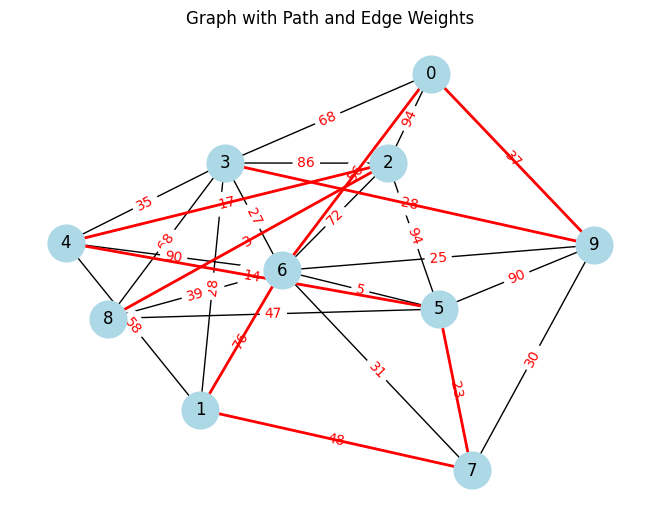

In [33]:
import numpy as np
import random
from matplotlib import pyplot as plt
import networkx as nx

def generate_random_symmetrical_graph(n):
    A = np.random.randint(0, 2, (n, n))
    A = np.triu(A, 1)
    A += A.T
    return tuple(tuple(row) for row in A)

def generate_random_weights(n, max_weight):
    weights = np.random.randint(1, max_weight, (n, n))
    weights = np.triu(weights, 1)
    weights += weights.T
    return tuple(tuple(row) for row in weights)

def generate_random_depot(n, num_objects):
    depots = [random.sample(range(n), random.randint(1, n)) for _ in range(num_objects)]
    print("Depot Locations:")
    for idx, depot in enumerate(depots):
        print(f"Object {idx + 1} can be picked up from cities: {depot}")
    return depots


def generate_random_delivery(n, num_objects):
    return {i: set(random.sample(range(n), random.randint(1, n))) for i in range(num_objects)}

def initialize_pheromones(n, initial_pheromone):
    return np.full((n, n), initial_pheromone)

def update_pheromones(pheromones, paths, decay, contribution, deliveries):
    for path, cost in paths:
        delivery_count = sum(1 for city in path if any(city in deliveries[obj] for obj in deliveries))
        for i, j in zip(path[:-1], path[1:]):
            pheromones[i][j] += (contribution / cost) * (delivery_count / len(deliveries))
    pheromones *= (1 - decay)
    return pheromones


def construct_path(n, graph, pheromones, weights, deliveries, num_time_steps):
    path = []
    cost = 0
    current_node = np.random.randint(n)  # Start at a random node
    visited = set()

    for t in range(num_time_steps):
        if current_node in deliveries and all([d in visited for d in deliveries[current_node]]):
            # If current node is a delivery node and all pickups are done
            visited.add(current_node)

        choices = [i for i in range(n) if graph[t][current_node][i] > 0 and i not in visited]
        if not choices:
            break  # If no available moves, break the loop

        # Select the next node based on pheromones and weights
        probabilities = [pheromones[current_node][i] * 1.0 / weights[t][current_node][i] for i in choices]
        probabilities /= np.sum(probabilities)
        next_node = np.random.choice(choices, p=probabilities)

        path.append((current_node, next_node))
        cost += weights[t][current_node][next_node]
        current_node = next_node

        if all(deliveries_required_completed(visited, deliveries)):
            break

    return path, cost





def ant_colony_optimization(n, pheromones, iterations, num_ants, graph, weights, deliveries):
    best_path = None
    best_cost = float('inf')

    for _ in range(iterations):
        paths = [construct_ant_path(n, graph, pheromones, weights, deliveries) for _ in range(num_ants)]
        for path, cost in paths:
            if cost < best_cost and set(path).issuperset(set().union(*deliveries.values())):
                best_path, best_cost = path, cost

        # Update pheromones only for paths meeting the delivery requirements
        valid_paths = [(path, cost) for path, cost in paths if set(path).issuperset(set().union(*deliveries.values()))]
        if valid_paths:
            update_pheromones(pheromones, valid_paths, decay=0.1, contribution=100, deliveries=deliveries)

    return best_path, best_cost



def draw_graph_with_path_and_weights(graph, path, weights):
    G = nx.Graph()
    for i in range(len(graph)):
        for j in range(i, len(graph[i])):
            if graph[i][j] > 0:
                G.add_edge(i, j, weight=weights[i][j])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.title('Graph with Path and Edge Weights')
    plt.show()



if __name__ == '__main__':
    n = 10  # Number of cities
    num_objects = 3  # Number of delivery objects

    graph = generate_random_symmetrical_graph(n)
    weights = generate_random_weights(n, 100)
    depots = generate_random_depot(n, num_objects)  # Generate and print depots
    deliveries = generate_random_delivery(n, num_objects)
    
    print("\nDelivery Locations:")
    for obj, locations in deliveries.items():
        print(f"Object {obj + 1} needs to be delivered to cities: {locations}")
    
    pheromones = initialize_pheromones(n, initial_pheromone=1.0)
    best_path, best_cost = ant_colony_optimization(n, pheromones, 100, 20, graph, weights, deliveries)

    if best_path:
        print("\nBest path meets all delivery requirements:", best_path)
        print("Cost of best path:", best_cost)
        draw_graph_with_path_and_weights(graph, best_path, weights)
    else:
        print("\nNo valid path found that meets all delivery requirements.")



Depot Locations:
Object 1 can be picked up from cities: [1, 0, 4, 3]
Object 2 can be picked up from cities: [1, 4, 2, 3, 0]
Object 3 can be picked up from cities: [0, 3]

Delivery Locations:
Object 1 needs to be delivered to cities: {3}
Object 2 needs to be delivered to cities: {0, 1, 3, 4}
Object 3 needs to be delivered to cities: {2, 3, 4}
Best path: [4, 1, 0, 2, 3]
Cost of best path: 200


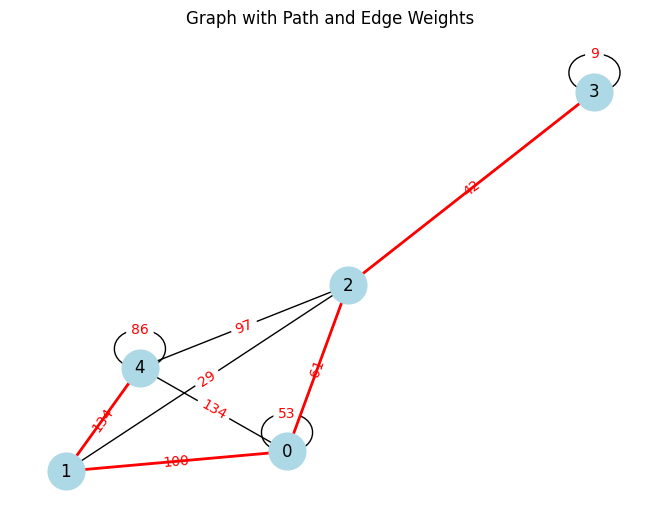

In [37]:
import numpy as np
import random
from matplotlib import pyplot as plt
import networkx as nx

# Constants for the ACO algorithm
NB_FOURMIS = 100  # Number of ants
NB_ITERATIONS = 100  # Number of iterations
ALPHA = 1.0  # Influence of pheromones
BETA = 2.0  # Influence of the heuristic (inverse of the distance)
RHO = 0.5  # Pheromone evaporation rate
Q = 100  # Quantity of pheromones deposited

def generate_random_symmetrical_graph(n):
    A = np.random.randint(0, 2, (n, n))
    A = np.triu(A, 1) + A.T
    return tuple(tuple(row) for row in A)

def generate_random_weights(n, max_weight):
    weights = np.random.randint(1, max_weight, (n, n))
    weights = np.triu(weights, 1) + weights.T
    return tuple(tuple(row) for row in weights)

def generate_random_depot(n, num_objects):
    depots = [random.sample(range(n), random.randint(1, n)) for _ in range(num_objects)]
    print("Depot Locations:")
    for idx, depot in enumerate(depots):
        print(f"Object {idx + 1} can be picked up from cities: {depot}")
    return depots

def generate_random_delivery(n, num_objects):
    return {i: set(random.sample(range(n), random.randint(1, n))) for i in range(num_objects)}

def initialize_pheromones(n, initial_pheromone):
    return np.full((n, n), initial_pheromone)

def update_pheromones(pheromones, paths, deliveries):
    for path, cost in paths:
        delivery_count = sum(1 for city in path if any(city in deliveries[obj] for obj in deliveries))
        for i, j in zip(path[:-1], path[1:]):
            pheromones[i][j] += (Q / cost) * (delivery_count / len(deliveries))  # Update with the Q constant
    pheromones *= (1 - RHO)  # Apply evaporation
    return pheromones

def construct_path(n, graph, pheromones, weights, deliveries):
    path = [random.randint(0, n-1)]  # Start at a random city
    cost = 0
    for _ in range(n-1):
        current = path[-1]
        choices = [i for i in range(n) if graph[current][i] > 0 and i not in path]
        if not choices:
            break
        probabilities = [pheromones[current][i] ** ALPHA * (1.0 / weights[current][i]) ** BETA for i in choices]
        total = sum(probabilities)
        probabilities = [p / total for p in probabilities]
        next_city = random.choices(choices, weights=probabilities, k=1)[0]
        path.append(next_city)
        cost += weights[current][next_city]
    return path, cost

def ant_colony_optimization(n, graph, weights, deliveries):
    pheromones = initialize_pheromones(n, 0.1)
    best_path, best_cost = None, float('inf')
    for _ in range(NB_ITERATIONS):
        paths = [construct_path(n, graph, pheromones, weights, deliveries) for _ in range(NB_FOURMIS)]
        valid_paths = [(path, cost) for path, cost in paths if set(path).issuperset(set().union(*deliveries.values()))]
        if valid_paths:
            path, cost = min(valid_paths, key=lambda x: x[1])
            if cost < best_cost:
                best_path, best_cost = path, cost
        update_pheromones(pheromones, valid_paths, deliveries)
    return best_path, best_cost

def draw_graph_with_path_and_weights(graph, path, weights):
    G = nx.Graph()
    for i in range(len(graph)):
        for j in range(i, len(graph[i])):
            if graph[i][j] > 0:
                G.add_edge(i, j, weight=weights[i][j])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.title('Graph with Path and Edge Weights')
    plt.show()

if __name__ == '__main__':
    n = 5
    num_objects = 3
    graph = generate_random_symmetrical_graph(n)
    weights = generate_random_weights(n, 100)
    depots = generate_random_depot(n, num_objects)
    deliveries = generate_random_delivery(n, num_objects)

    print("\nDelivery Locations:")
    for obj, locations in deliveries.items():
        print(f"Object {obj + 1} needs to be delivered to cities: {locations}")
    
    best_path, best_cost = ant_colony_optimization(n, graph, weights, deliveries)
    print("Best path:", best_path)
    print("Cost of best path:", best_cost)
    draw_graph_with_path_and_weights(graph, best_path, weights)


Depot Locations:
Object 1 can be picked up from cities: [3, 4, 0, 2]
Object 2 can be picked up from cities: [3, 0, 2, 4]

Delivery Locations:
Object 1 needs to be delivered to cities: [1, 0, 3, 2]
Object 2 needs to be delivered to cities: [2, 1, 3]
Best path: [0, 2, 3, 4, 1, 0]
Cost of best path: 423


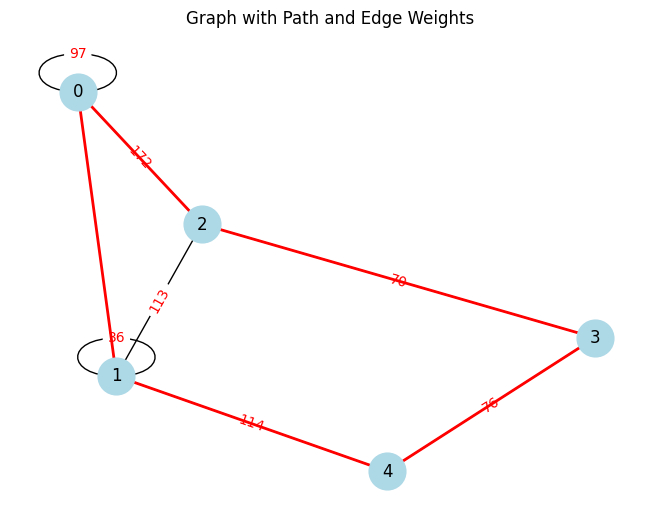

In [19]:
import numpy as np
import random
from matplotlib import pyplot as plt
import networkx as nx

# Constants for the ACO algorithm
NB_FOURMIS = 100  # Number of ants
NB_ITERATIONS = 100  # Number of iterations
ALPHA = 1.0  # Influence of pheromones
BETA = 2.0  # Influence of the heuristic (inverse of the distance)
RHO = 0.5  # Pheromone evaporation rate
Q = 100  # Quantity of pheromones deposited

def generate_random_symmetrical_graph(n):
    A = np.random.randint(0, 2, (n, n))
    A = np.triu(A, 1) + A.T
    return tuple(tuple(row) for row in A)

def generate_random_weights(n, max_weight):
    weights = np.random.randint(1, max_weight, (n, n))
    weights = np.triu(weights, 1) + weights.T
    return tuple(tuple(row) for row in weights)

def generate_random_depot(n, num_objects):
    depots = [random.sample(range(n), random.randint(1, n)) for _ in range(num_objects)]
    print("Depot Locations:")
    for idx, depot in enumerate(depots):
        print(f"Object {idx + 1} can be picked up from cities: {depot}")
    return depots

def generate_random_delivery(n, num_objects):
    deliveries = {
        "pickup": {i: random.sample(range(n), random.randint(1, n)) for i in range(num_objects)},
        "delivery": {i: random.sample(range(n), random.randint(1, n)) for i in range(num_objects)}
    }
    return deliveries

def initialize_pheromones(n, initial_pheromone):
    return np.full((n, n), initial_pheromone)

def update_pheromones(pheromones, paths, deliveries):
    for path, cost in paths:
        delivery_count = sum(1 for city in path if any(city in deliveries["delivery"][obj] for obj in deliveries["delivery"]))
        for i, j in zip(path[:-1], path[1:]):
            pheromones[i][j] += (Q / cost) * (delivery_count / len(deliveries["delivery"]))
    pheromones *= (1 - RHO)
    return pheromones

def construct_path(n, graph, pheromones, weights, deliveries, start_city=0):
    path = [start_city]  # Start at the initial city
    cost = 0
    visited = set(path)
    collected_items = set()
    delivered_items = set()
    current_node = start_city

    while True:
        current = path[-1]
        choices = [i for i in range(n) if graph[current][i] > 0 and (i not in visited or any(deliveries["delivery"][obj] == i for obj in collected_items))]
        
        if not choices:
            break

        probabilities = [pheromones[current][i] ** ALPHA * (1.0 / weights[current][i]) ** BETA for i in choices]
        total = sum(probabilities)
        probabilities = [p / total for p in probabilities]
        next_city = random.choices(choices, weights=probabilities, k=1)[0]

        # # Handle pickup
        # for obj, locations in deliveries["pickup"].items():
        #     if next_city in locations and obj not in collected_items:
        #         collected_items.add(obj)
        #         print(f"Collected Object {obj + 1} from City {next_city}")
        #         break

        # # Handle delivery
        # for obj, locations in deliveries["delivery"].items():
        #     if next_city in locations and obj in collected_items and obj not in delivered_items:
        #         delivered_items.add(obj)
        #         print(f"Delivered Object {obj + 1} to City {next_city}")
        #         break

        path.append(next_city)
        visited.add(next_city)
        cost += weights[current][next_city]

        # Check if all deliveries are done and return to start city
        if len(delivered_items) == len(deliveries["delivery"]) and next_city == start_city:
            break

    # Ensure to return to start city
    if path[-1] != start_city:
        path.append(start_city)
        cost += weights[path[-2]][start_city]

    return path, cost

def ant_colony_optimization(n, graph, weights, deliveries):
    pheromones = initialize_pheromones(n, 0.1)
    best_path, best_cost = None, float('inf')
    for _ in range(NB_ITERATIONS):
        paths = [construct_path(n, graph, pheromones, weights, deliveries) for _ in range(NB_FOURMIS)]
        valid_paths = [(path, cost) for path, cost in paths if set(path).issuperset(set().union(*deliveries["delivery"].values()))]
        if valid_paths:
            path, cost = min(valid_paths, key=lambda x: x[1])
            if cost < best_cost:
                best_path, best_cost = path, cost
        update_pheromones(pheromones, valid_paths, deliveries)
    return best_path, best_cost

def draw_graph_with_path_and_weights(graph, path, weights):
    G = nx.Graph()
    for i in range(len(graph)):
        for j in range(i, len(graph[i])):
            if graph[i][j] > 0:
                G.add_edge(i, j, weight=weights[i][j])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.title('Graph with Path and Edge Weights')
    plt.show()

if __name__ == '__main__':
    n = 5
    num_objects = 2
    graph = generate_random_symmetrical_graph(n)
    weights = generate_random_weights(n, 100)
    depots = generate_random_depot(n, num_objects)
    deliveries = generate_random_delivery(n, num_objects)

    print("\nDelivery Locations:")
    for obj, locations in deliveries["delivery"].items():
        print(f"Object {obj + 1} needs to be delivered to cities: {locations}")
    
    best_path, best_cost = ant_colony_optimization(n, graph, weights, deliveries)
    print("Best path:", best_path)
    print("Cost of best path:", best_cost)
    draw_graph_with_path_and_weights(graph, best_path, weights)


Depot Locations:
Object 1 can be picked up from cities: [1, 4, 0, 3]
Object 2 can be picked up from cities: [1, 4, 3, 0, 2]
Object 3 can be picked up from cities: [2, 4, 0, 1]
Object 4 can be picked up from cities: [3, 0]

Delivery Locations:
Object 1 needs to be delivered to cities: [4]
Object 2 needs to be delivered to cities: [0, 3]
Object 3 needs to be delivered to cities: [2, 1, 4, 3]
Object 4 needs to be delivered to cities: [4, 2, 1, 3]
Best path starting from city 2 : [2, 1, 4, 0, 3, 2]
Cost of best path: 231

Edge weights for the best path:
Edge from 2 to 1 with weight 46
Edge from 1 to 4 with weight 25
Edge from 4 to 0 with weight 88
Edge from 0 to 3 with weight 34
Edge from 3 to 2 with weight 38


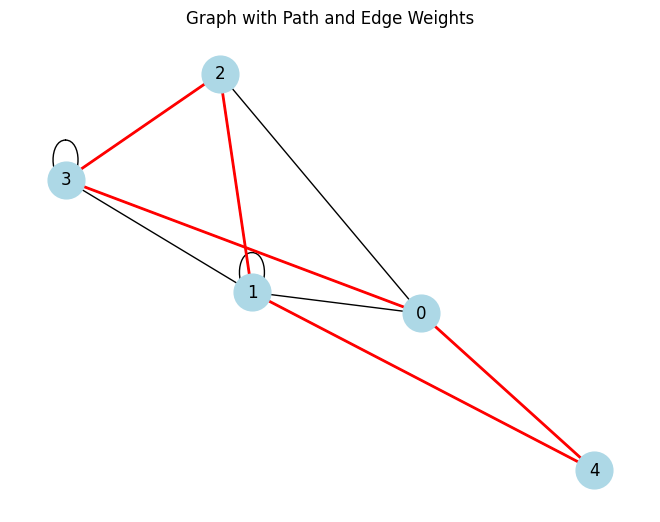

In [32]:
import numpy as np
import random
from matplotlib import pyplot as plt
import networkx as nx

# Constants for the ACO algorithm
NB_FOURMIS = 100  # Number of ants
NB_ITERATIONS = 100  # Number of iterations
ALPHA = 1.0  # Influence of pheromones
BETA = 2.0  # Influence of the heuristic (inverse of the distance)
RHO = 0.5  # Pheromone evaporation rate
Q = 100  # Quantity of pheromones deposited

def generate_random_symmetrical_graph(n):
    A = np.random.randint(0, 2, (n, n))
    A = np.triu(A, 1) + A.T
    return tuple(tuple(row) for row in A)

def generate_random_weights(n, max_weight):
    weights = np.random.randint(1, max_weight, (n, n))
    weights = np.triu(weights, 1) + weights.T
    return tuple(tuple(row) for row in weights)

def generate_random_depot(n, num_objects):
    depots = [random.sample(range(n), random.randint(1, n)) for _ in range(num_objects)]
    print("Depot Locations:")
    for idx, depot in enumerate(depots):
        print(f"Object {idx + 1} can be picked up from cities: {depot}")
    return depots

def generate_random_delivery(n, num_objects):
    deliveries = {
        "pickup": {i: random.sample(range(n), random.randint(1, n)) for i in range(num_objects)},
        "delivery": {i: random.sample(range(n), random.randint(1, n)) for i in range(num_objects)}
    }
    return deliveries

def initialize_pheromones(n, initial_pheromone):
    return np.full((n, n), initial_pheromone)

def update_pheromones(pheromones, paths, deliveries):
    for path, cost in paths:
        delivery_count = sum(1 for city in path if any(city in deliveries["delivery"][obj] for obj in deliveries["delivery"]))
        for i, j in zip(path[:-1], path[1:]):
            pheromones[i][j] += (Q / cost) * (delivery_count / len(deliveries["delivery"]))
    pheromones *= (1 - RHO)
    return pheromones

def construct_path(n, graph, pheromones, weights, deliveries, start_city):
    path = [start_city]  # Start at the initial city
    cost = 0
    visited = set(path)
    collected_items = set()
    delivered_items = set()
    current_node = start_city

    while True:
        current = path[-1]
        choices = [i for i in range(n) if graph[current][i] > 0 and (i not in visited or any(deliveries["delivery"][obj] == i for obj in collected_items))]
        
        if not choices:
            break

        probabilities = [pheromones[current][i] ** ALPHA * (1.0 / weights[current][i]) ** BETA for i in choices]
        total = sum(probabilities)
        probabilities = [p / total for p in probabilities]
        next_city = random.choices(choices, weights=probabilities, k=1)[0]

        # # Handle pickup
        # for obj, locations in deliveries["pickup"].items():
        #     if next_city in locations and obj not in collected_items:
        #         collected_items.add(obj)
        #         print(f"Collected Object {obj + 1} from City {next_city}")
        #         break

        # # Handle delivery
        # for obj, locations in deliveries["delivery"].items():
        #     if next_city in locations and obj in collected_items and obj not in delivered_items:
        #         delivered_items.add(obj)
        #         print(f"Delivered Object {obj + 1} to City {next_city}")
        #         break

        path.append(next_city)
        visited.add(next_city)
        cost += weights[current][next_city]

        # Check if all deliveries are done and return to start city
        if len(delivered_items) == len(deliveries["delivery"]) and next_city == start_city:
            break

    # Ensure to return to start city
    if path[-1] != start_city:
        path.append(start_city)
        cost += weights[path[-2]][start_city]

    return path, cost

def ant_colony_optimization(n, graph, weights, deliveries):
    start_city = random.randint(0, n-1)  # Choose a random start city
    pheromones = initialize_pheromones(n, 0.1)
    best_path, best_cost = None, float('inf')
    for _ in range(NB_ITERATIONS):
        paths = [construct_path(n, graph, pheromones, weights, deliveries, start_city) for _ in range(NB_FOURMIS)]
        valid_paths = [(path, cost) for path, cost in paths if set(path).issuperset(set().union(*deliveries["delivery"].values()))]
        if valid_paths:
            path, cost = min(valid_paths, key=lambda x: x[1])
            if cost < best_cost:
                best_path, best_cost = path, cost
        update_pheromones(pheromones, valid_paths, deliveries)
    return best_path, best_cost, start_city

def draw_graph_with_path_and_weights(graph, path, weights):
    G = nx.Graph()
    for i in range(len(graph)):
        for j in range(i, len(graph[i])):
            if graph[i][j] > 0:
                G.add_edge(i, j, weight=weights[i][j])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
    # Remove edge labels
    # edge_labels = {(i, j): weights[i][j] for i, j in G.edges()}  # Correctly set edge labels to match weights used
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.title('Graph with Path and Edge Weights')
    plt.show()

if __name__ == '__main__':
    n = 5
    num_objects = 4
    graph = generate_random_symmetrical_graph(n)
    weights = generate_random_weights(n, 100)
    depots = generate_random_depot(n, num_objects)
    deliveries = generate_random_delivery(n, num_objects)

    print("\nDelivery Locations:")
    for obj, locations in deliveries["delivery"].items():
        print(f"Object {obj + 1} needs to be delivered to cities: {locations}")
    
    best_path, best_cost, start_city = ant_colony_optimization(n, graph, weights, deliveries)
    print("Best path starting from city", start_city, ":", best_path)
    print("Cost of best path:", best_cost)
    print("\nEdge weights for the best path:")
    for i in range(len(best_path) - 1):
        print(f"Edge from {best_path[i]} to {best_path[i+1]} with weight {weights[best_path[i]][best_path[i+1]]}")
    draw_graph_with_path_and_weights(graph, best_path, weights)


Depot Locations:
Object 1 can be picked up from cities: [3, 2, 4, 1, 0]
Object 2 can be picked up from cities: [2, 1]
Object 3 can be picked up from cities: [3]
Object 4 can be picked up from cities: [0, 4]

Delivery Locations:
Object 1 needs to be delivered to cities: [2, 4, 3, 0, 1]
Object 2 needs to be delivered to cities: [4, 2, 0, 3]
Object 3 needs to be delivered to cities: [0, 1, 2, 3, 4]
Object 4 needs to be delivered to cities: [0, 1]
Best path starting from city 3 : [3, 0, 2, 1, 4, 3]
Cost of best path: 229

Edge weights for the best path:
Edge from 3 to 0 with weight 76
Edge from 0 to 2 with weight 67
Edge from 2 to 1 with weight 60
Edge from 1 to 4 with weight 18
Edge from 4 to 3 with weight 8


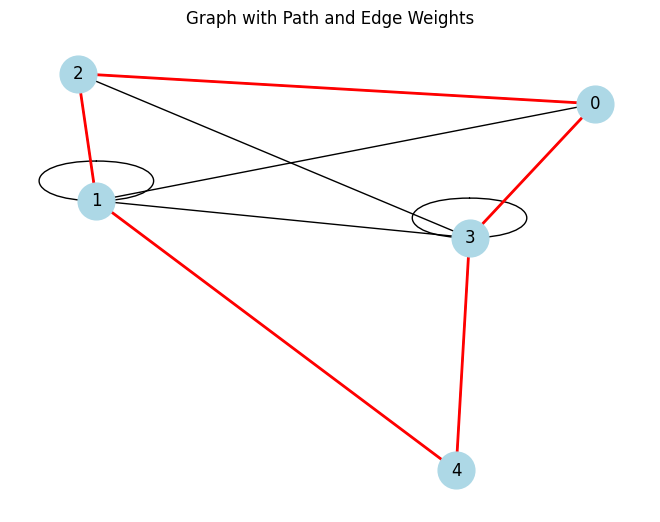

In [49]:
import numpy as np
import random
from matplotlib import pyplot as plt
import networkx as nx

# Constants for the ACO algorithm
NB_FOURMIS = 100  # Number of ants
NB_ITERATIONS = 100  # Number of iterations
ALPHA = 1.0  # Influence of pheromones
BETA = 2.0  # Influence of the heuristic (inverse of the distance)
RHO = 0.5  # Pheromone evaporation rate
Q = 100  # Quantity of pheromones deposited

def generate_random_symmetrical_graph(n):
    A = np.random.randint(0, 2, (n, n))
    A = np.triu(A, 1) + A.T
    return tuple(tuple(row) for row in A)

def generate_random_weights(n, max_weight):
    weights = np.random.randint(1, max_weight, (n, n))
    weights = np.triu(weights, 1) + weights.T
    return tuple(tuple(row) for row in weights)

def generate_random_depot(n, num_objects):
    depots = [random.sample(range(n), random.randint(1, n)) for _ in range(num_objects)]
    print("Depot Locations:")
    for idx, depot in enumerate(depots):
        print(f"Object {idx + 1} can be picked up from cities: {depot}")
    return depots

def generate_random_delivery(n, num_objects):
    deliveries = {
        "pickup": {i: random.sample(range(n), random.randint(1, n)) for i in range(num_objects)},
        "delivery": {i: random.sample(range(n), random.randint(1, n)) for i in range(num_objects)}
    }
    return deliveries

def initialize_pheromones(n, initial_pheromone):
    return np.full((n, n), initial_pheromone)

def update_pheromones(pheromones, paths, deliveries):
    for path, cost in paths:
        delivery_count = sum(1 for city in path if any(city in deliveries["delivery"][obj] for obj in deliveries["delivery"]))
        for i, j in zip(path[:-1], path[1:]):
            pheromones[i][j] += (Q / cost) * (delivery_count / len(deliveries["delivery"]))
    pheromones *= (1 - RHO)
    return pheromones

def all_deliveries_completed(deliveries, path, collected_items):
    for obj, delivery_locs in deliveries["delivery"].items():
        if obj in collected_items:  # Only check for objects that have been collected
            for loc in delivery_locs:
                if loc not in path or path.index(loc) <= max(path.index(pick) for pick in deliveries["pickup"][obj] if pick in path):
                    return False
    return True


def construct_path(n, graph, pheromones, weights, deliveries, start_city):
    path = [start_city]  # Start at the initial city
    cost = 0
    visited = set(path)
    collected_items = set()
    delivered_items = set()

    while True:
        current = path[-1]
        # Initially consider all possible next cities
        choices = [i for i in range(n) if graph[current][i] > 0 and i not in visited]

        # Filter choices to avoid going to delivery locations without required items
        filtered_choices = [i for i in choices if not any(i in deliveries["delivery"][obj] and obj not in collected_items for obj in deliveries["delivery"])]

        # Use filtered choices if available, otherwise consider all choices (may revisit for valid delivery)
        choices = filtered_choices if filtered_choices else choices

        if not choices:
            break  # If no choices left, exit the loop

        probabilities = [pheromones[current][i] ** ALPHA * (1.0 / weights[current][i]) ** BETA for i in choices]
        total = sum(probabilities)
        probabilities = [p / total for p in probabilities]
        next_city = random.choices(choices, weights=probabilities, k=1)[0]

        path.append(next_city)
        visited.add(next_city)
        cost += weights[current][next_city]

        # Handle pickup of items
        for obj, locations in deliveries["pickup"].items():
            if next_city in locations and obj not in collected_items:
                collected_items.add(obj)

        # Handle delivery of items
        for obj, locations in deliveries["delivery"].items():
            if next_city in locations and obj in collected_items:
                delivered_items.add(obj)

        # If all required deliveries are done, possibly break the loop
        if set(deliveries["delivery"].keys()) == delivered_items and next_city == start_city:
            break

    # Ensure to return to start city if not already there
    if path[-1] != start_city:
        path.append(start_city)
        cost += weights[path[-2]][start_city]

    return path, cost

def ant_colony_optimization(n, graph, weights, deliveries):
    start_city = random.randint(0, n-1)  # Choose a random start city
    pheromones = initialize_pheromones(n, 0.1)
    best_path, best_cost = None, float('inf')
    for _ in range(NB_ITERATIONS):
        paths = [construct_path(n, graph, pheromones, weights, deliveries, start_city) for _ in range(NB_FOURMIS)]
        valid_paths = [(path, cost) for path, cost in paths if set(path).issuperset(set().union(*deliveries["delivery"].values()))]
        if valid_paths:
            path, cost = min(valid_paths, key=lambda x: x[1])
            if cost < best_cost:
                best_path, best_cost = path, cost
        update_pheromones(pheromones, valid_paths, deliveries)
    return best_path, best_cost, start_city

def draw_graph_with_path_and_weights(graph, path, weights):
    G = nx.Graph()
    for i in range(len(graph)):
        for j in range(i, len(graph[i])):
            if graph[i][j] > 0:
                G.add_edge(i, j, weight=weights[i][j])
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=700)
    # Remove edge labels
    # edge_labels = {(i, j): weights[i][j] for i, j in G.edges()}  # Correctly set edge labels to match weights used
    # nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='r', width=2)
    plt.title('Graph with Path and Edge Weights')
    plt.show()

if __name__ == '__main__':
    n = 5
    num_objects = 4
    graph = generate_random_symmetrical_graph(n)
    weights = generate_random_weights(n, 100)
    depots = generate_random_depot(n, num_objects)
    deliveries = generate_random_delivery(n, num_objects)

    print("\nDelivery Locations:")
    for obj, locations in deliveries["delivery"].items():
        print(f"Object {obj + 1} needs to be delivered to cities: {locations}")
    
    best_path, best_cost, start_city = ant_colony_optimization(n, graph, weights, deliveries)
if best_path is not None:
    print("Best path starting from city", start_city, ":", best_path)
    print("Cost of best path:", best_cost)
    print("\nEdge weights for the best path:")
    for i in range(len(best_path) - 1):
        print(f"Edge from {best_path[i]} to {best_path[i+1]} with weight {weights[best_path[i]][best_path[i+1]]}")
    draw_graph_with_path_and_weights(graph, best_path, weights)
else:
    print("No valid path was found that meets all delivery requirements.")

